In [ ]:
from google.colab import files
upload = files.upload()


Saving housing.csv to housing.csv


In [ ]:
import io
import pandas as pd
housing = pd.read_csv(io.BytesIO(upload['housing.csv']))
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,Unnamed: 10,Unnamed: 11
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,0.0,0.0
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN,NaN
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,NaN,NaN


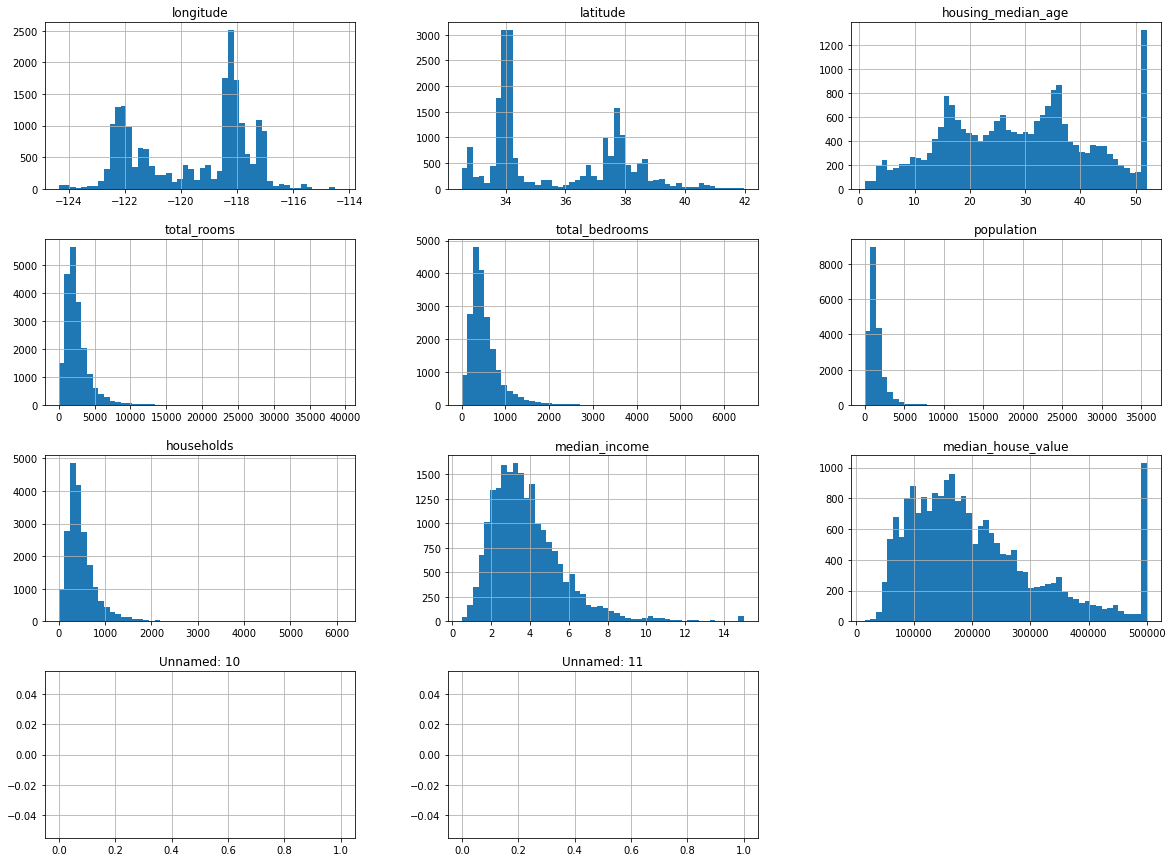

In [ ]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
import numpy as np
# This is not good practice because next time when we run this code again test
# instance will shuffle again causing machine learning algorithm to see the 
# whole data set which we want to avoid. In short this is not a good approach. 
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)* test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices],data.iloc[test_indices]
train_set,test_set = split_train_test(housing,0.2)


In [ ]:
# Optimal Approach work for updated dataset as well
# We will calculate the hash value of each instance's identifier
# if the hash value of identifier is less than or equal to 2o% of the maximum
# hash value it will be allowed to go into test set elsewise be in the training set.
# crc32 is a method we can import a method as well
from zlib import crc32
# CRC stands for cyclic redundancy check it is a value that checks wether
# data is same when decompress it or it is changed. Ofcouse when calculating the 
# checksum value, the data should be of byte type.
def test_set_check(identifier, test_ratio):
  # 0xffffffff is euivalent to 4294967295
  return crc32(np.int64(identifier)) <test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [ ]:
# Another random sampling method is through scikit_learn train_test_ split method
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 45)
test_set.head()


      

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Unnamed: 10,Unnamed: 11,Unnamed: 12
3046,-119.28,35.50,34,1923,379.0,1101,351,2.4044,65800,INLAND,NaN,NaN,NaN
6803,-118.13,34.08,40,1931,449.0,1367,446,2.5750,228400,<1H OCEAN,NaN,NaN,NaN
10112,-117.94,33.94,30,1596,307.0,845,309,4.5096,241100,<1H OCEAN,NaN,NaN,NaN
3126,-117.79,35.21,4,2,2.0,6,2,2.3750,137500,INLAND,NaN,NaN,NaN
5008,-118.33,34.01,47,1320,259.0,653,291,3.7727,193000,<1H OCEAN,NaN,NaN,NaN


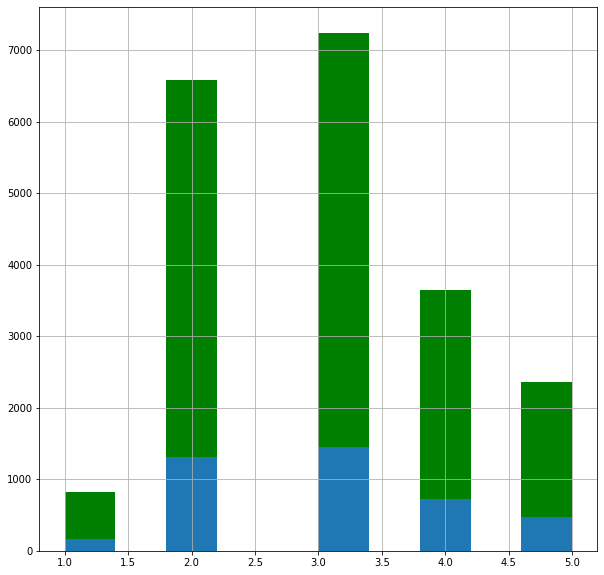

In [ ]:
# Test set should contains all the possible instances for different data categories for fair testing eslewise biased 
# we can create an attribe in pandas frame like this
# we can refer the term strata for category
# np.inf is a numpy constant for infinity
# we will be going for another sampling called stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6.,  np.inf], labels = [1,2,3,4,5])
housing["income_cat"].hist(color="green", figsize= (10,10))
# Now we are ready for the stratified sampling using scikit learn's StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]
strat_test_set["income_cat"].hist()
# Now we got all instances assoiciated with all the categories in test set, so 
# we should remove income categroy attribute now.
# In this for loop we have removed income_cat attribute from both training
# and testing set
for set_ in (strat_train_set,strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True)


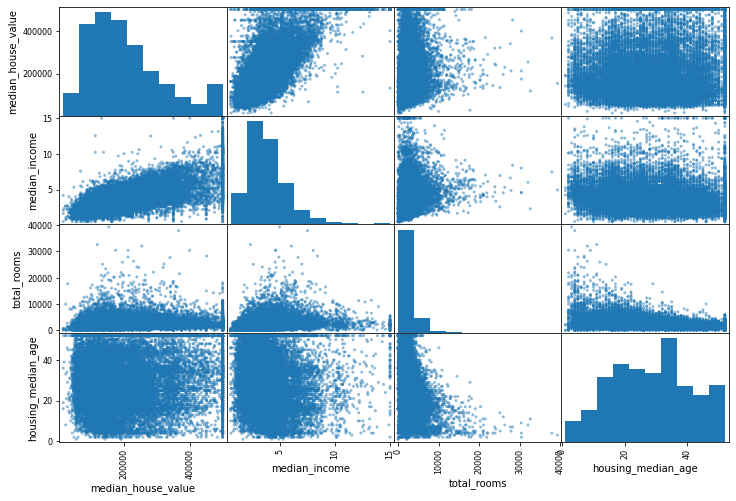

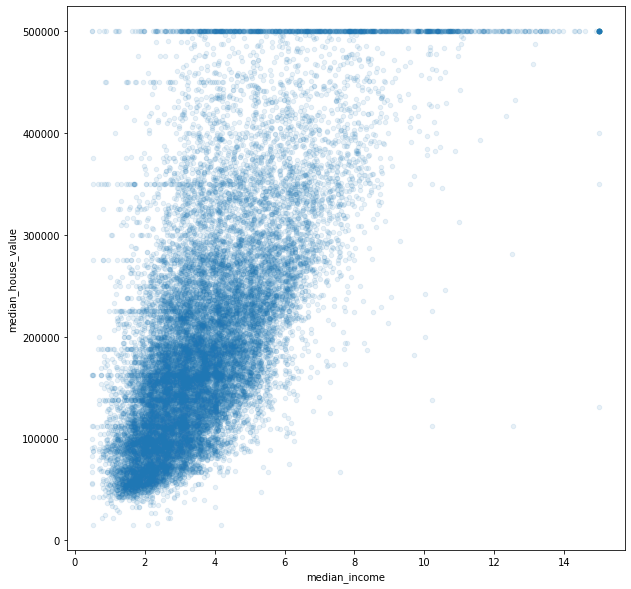

In [ ]:
# Looking For correlations
# Dealing here with linear correlations using karl persons corelation coffiecient
# also called standard correlation cofficient
corr_matrix = housing.corr()
# i want to see how the attributes correlates with median housing values
corr_matrix["median_house_value"].sort_values(ascending = False)
# We can also use pandas scatter_matrix function for the calculation of 
# correlation using plots i.e visualization of correlation
from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
# Zooming correlation between median income and median house values
housing.plot(kind= "scatter", x= "median_income", y="median_house_value", alpha = 0.1,figsize= (10,10))



In [ ]:
#Experimenting with attribute combinations
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing["population_per_household"].head()
# Checking the correlation of the new attributes with the target attribute
# Making Correltation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_rooms         -0.255880
Unnamed: 10                      NaN
Unnamed: 11                      NaN
Name: median_house_value, dtype: float64

In [ ]:
# Its time to prepare the data for the machine learning algorithm
# Creating the copy of stratified training set by separating predictors and 
# labels
housing = strat_train_set.drop(["median_house_value",'Unnamed: 10',	'Unnamed: 11',	'Unnamed: 12'], axis = 1)
housing_label = strat_train_set["median_house_value"].copy() 
# Cleaning Data
# first we will handle null values in feature instances
# we will calculate median values and replace null values with it
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")
# Since median is only for the numerical attributes, therefore we need a 
# dataframe with only numerical attributes.
housing_num =  housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)
# we have filled null values with median values
# To see the median values of each attribute
#imputer.statistics_
X = imputer.transform(housing_num)
# it will return numpy array which we will convert into pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [ ]:
# Handling Text and Categorical Attributes
# We have left ocean_proximity attributes because its a textual attribute
# We have to tackle this attribute as well
housing_cat = housing[["ocean_proximity"]]
# we have to convert this textual attribute into a numerical format because
# most machine learning algorithms works best with numbers rather than text.
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# now we are going to encode our categorical attribute
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:20]
# if we want to see the categories which are encoded, we can see them using
# categories_ instance variable
ordinal_encoder.categories_
# One Hot Encoding for dealing with non ordered categories
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# converting scipy sparse matrix to numpy array
housing_cat_1hot.toarray()
cat_encoder.categories_



[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# Coustom transformer class
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
# parameters in the constructor is sometimes called as hyperparamters
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,
      bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
# Creating object of our custom class
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
# .values will return pandas dataframe values in form of list 
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
# Feature Scaling
# Feature scaling is for features only not for target attributes
# Featrue scaling simply means all attributes have same value range
# Transformer simply means class
# We will be using standardization instead of min_max scaling
# All these datatransformation can be handling using scikit learn pipeline class
# Pipe line will work only if all the estimators have fit_transform method()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
                         ('imputer',SimpleImputer(strategy="median")),
                         ("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr[4]


array([ 0.49247384, -0.65929936, -0.92673619,  1.85619316,  2.41221109,
        2.72415407,  2.57097492, -0.44143679, -0.35783383, -0.00419445,
        0.2699277 ])

In [ ]:
# Now its time to transform full housing data using columnTransformer Class
# handling categorical attributes along with other attributes
# if we only want to see the names of feature from the dataframe we can use
# list() method
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38,1568,351.0,710,339,2.7042,<1H OCEAN
18632,-121.93,37.05,14,679,108.0,306,113,6.4214,<1H OCEAN
14650,-117.20,32.77,31,1952,471.0,936,462,2.8621,NEAR OCEAN
3230,-119.61,36.31,25,1847,371.0,1460,353,1.8839,INLAND
3555,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347,<1H OCEAN


In [ ]:
# Now its time for the selection and training of model
# first we have selected linear regression model
# housing prepared contains features, and housing_label contains
# Output
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_label)
some_labels = housing_label.iloc[:5]
# Now taking few rows from training set to check out the model
print("Predictions:",lin_reg.predict(housing_prepared)[:5])
print("Expected Output:", list(some_labels))
# To check Models Performance we use RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("ROOT MEAN ERROR:", lin_rmse)



  

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Expected Output: [286600, 340600, 196900, 46300, 254500]
ROOT MEAN ERROR: 68628.19819848923


In [ ]:
# Now we will try more complex model that can handle non linear relationships 
# between the data and that is descision tree regression
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_label)
tree_housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label,tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("ROOT MEAN ERROR:", tree_rmse)
# The model is badly overfitting the training data. This is the method to ensure
# model underfitting. We will assure it using cross validation. Standard Deviation
# is calculated for checking the precision of the model.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring= "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores
def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard Deviation: ", scores.std())
display_scores(tree_rmse_scores)







ROOT MEAN ERROR: 0.0
Scores:  [69315.35920494 66988.52883566 71158.09083052 69088.06521546
 70579.00030626 74713.5808048  71667.74734065 71497.0822956
 75990.82839823 69660.07195656]
Mean:  71065.83551886701
Standard Deviation:  2528.4725706227573


In [ ]:
# This model works best for us.
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)
forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_label,forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("ROOT MEAN ERROR:", forest_rmse)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, housing_prepared, housing_label, scoring= "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)


ROOT MEAN ERROR: 18704.594006234052
Scores:  [49667.21768022 47320.56978161 49804.27773681 52185.61580384
 49278.53854253 53701.84367599 48731.42674164 47808.534552
 53058.80926041 50215.10038181]
Mean:  50177.19341568694
Standard Deviation:  2045.235276728538


In [ ]:
# Its time to fine tune our model for optimizing the performance of the model
# by finding best combinations for models hyperparameters.
from sklearn.model_selection import GridSearchCV
params_grid = [
               {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
               {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,params_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared,housing_label)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
# Now we would have best combinations for hyperparameters
grid_search.best_params_
grid_search.best_estimator_
# We can also have the cross-validations results for 5 folds
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score),params)


64744.39780399072 {'max_features': 2, 'n_estimators': 3}
55703.86239110415 {'max_features': 2, 'n_estimators': 10}
53199.677488766356 {'max_features': 2, 'n_estimators': 30}
60118.92900423581 {'max_features': 4, 'n_estimators': 3}
53318.36873443444 {'max_features': 4, 'n_estimators': 10}
50117.58783224079 {'max_features': 4, 'n_estimators': 30}
59142.52590960412 {'max_features': 6, 'n_estimators': 3}
52206.43311041944 {'max_features': 6, 'n_estimators': 10}
50148.77187205799 {'max_features': 6, 'n_estimators': 30}
58593.75045286719 {'max_features': 8, 'n_estimators': 3}
51723.28409112123 {'max_features': 8, 'n_estimators': 10}
49971.32559139572 {'max_features': 8, 'n_estimators': 30}
62575.35486481464 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54330.86039634188 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59294.17269329324 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53093.693758679714 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [ ]:
# Its time to Analyze our best model to get insight about the importance
# of different features regarding their contributions in the predictions.
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances 
# Lets display the feature importance score along with feature name
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# To see which tranformer is used with that name in the pipeline
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
# In this way we can get the list of all the attributes on which the transformations
# are applied so far
sorted(zip(feature_importances, attributes),reverse = True)

[(0.3493850697457962, 'median_income'),
 (0.1600707442906288, 'INLAND'),
 (0.11542614083002663, 'pop_per_hhold'),
 (0.069279267824546, 'longitude'),
 (0.06728766282719897, 'bedrooms_per_room'),
 (0.06185104298214169, 'rooms_per_hhold'),
 (0.060020623470244686, 'latitude'),
 (0.042877769792790565, 'housing_median_age'),
 (0.014987769242981152, 'total_rooms'),
 (0.014982853444629678, 'population'),
 (0.014628102015735509, 'households'),
 (0.01444165195660493, 'total_bedrooms'),
 (0.009014911369513925, '<1H OCEAN'),
 (0.0033955542279645234, 'NEAR OCEAN'),
 (0.0023034823515323973, 'NEAR BAY'),
 (4.735362766437228e-05, 'ISLAND')]

In [ ]:
# Its finally the time to evaulate our system on the test set
final_model= grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis =1)
Y_test = strat_test_set["median_house_value"].copy()
# The fit method is calculating the mean and variance of each of the features
# present in our data. The transform method is transforming all the features
# using the respective mean and variance.
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
# 48648.986006755775 got our score.
# For getting Precision on the generalization error
# Confidence intervals about mean an important statistical concept
from scipy import stats
confidence = 0.95
squared_errors  = (final_predictions - Y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors-1),loc = squared_errors.mean(),scale = stats.sem(squared_errors)))
# This provides the confidence that our model can never go beyound this range
# in the generalization error.
# That all for the project. 


/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([46565.81149196, 50646.54854051])